In [98]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os
import glob

In [99]:
# load and save functions
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name , 'rb') as f:
        return pd.DataFrame(pickle.load(f))

### CNN on the 'model' data to predict subclass

In [100]:
from sklearn.metrics import confusion_matrix #, classification_report, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras import backend as tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils
from keras.initializers import random_uniform
from keras import layers
from keras.optimizers import RMSprop

In [101]:
# load all spectra in internal memory 
locationSpectra = 'spectra_matched/'
filenames = glob.glob(locationSpectra+'*pkl')

cut_off = 5000

X = np.zeros((len(filenames),cut_off))
X_scaled = np.zeros((len(filenames),cut_off,1))
y = []

sc = MinMaxScaler()

counter_excluded = 0
for i in range(len(filenames)):
    df_current = load_obj(filenames[i])
    l = len(df_current['flux'])
    X[i][0:l] = df_current['flux'][0:l]
    
    # Scale result in new array
    X_scaled[i] = sc.fit_transform(X[i].reshape(cut_off,1))
    
    y.append(df_current['class'].iloc[0])
X = X[0:(len(X)-counter_excluded)]
y = np.array(y)

In [102]:
# encode class values as integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_Y)

def decode(dummy_y,encoder):
    """
    Function that takes the dummy variable and its encoder and transforms it
    back to the initial form
    """
    # from dummy back to class names
    encoded_y = np.zeros(len(dummy_y))
    for i in range(len(dummy_y)):
        encoded_y[i] = int(np.argmax(dummy_y[i]))
    classes_y =  encoder.inverse_transform(encoded_y.astype(int))
    
    return classes_y,encoded_y

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.1,  random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [104]:
# Enter target names 
target_names = ['GALAXY', 'QSO', 'STAR']
numberTargets = len(target_names) # Useful later (for the final dense layer of CNN).

# Reshape for CNN. (Honestly, I'm not sure why this makes a difference) 
X_train = np.reshape(X_train, (np.size(X_train,0), np.size(X_train,1), 1))
X_test = np.reshape(X_test, (np.size(X_test,0), np.size(X_test,1), 1))
X_val = np.reshape(X_val, (np.size(X_val,0), np.size(X_val,1), 1))

In [108]:
# Choose hyperparameters
no_epochs = 20
batch_size = 64
learning_rate = 0.0100
dropout_rate = 0.20

# Design the Network
model = Sequential()
model.add(layers.Conv1D(32, 6, activation='relu',  input_shape=X_train[0].shape)) # Input shape is VERY fiddly. May need to try different things. 
model.add(Dropout(dropout_rate))
model.add(layers.Conv1D(64, 4, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(Dense(numberTargets, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 4995, 16)          112       
_________________________________________________________________
dropout_7 (Dropout)          (None, 4995, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4992, 32)          2080      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 2,291
Trainable params: 2,291
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
model.compile(optimizer=RMSprop(lr=learning_rate),
              loss='categorical_crossentropy', # May need to change to binary_crossentropy or categorical_crossentropy
              metrics=['acc'])
history = model.fit(X_train, y_train, epochs=no_epochs, batch_size=batch_size, validation_data=(X_val, y_val))
predictions = model.predict_proba(X_test)
predicted_labels = predictions.argmax(axis=1) # Converts probabilities (e.g. 0.035 0.001 0.704 0.260) to labels (e.g. 0 0 1 0)

Train on 2322 samples, validate on 259 samples
Epoch 1/20
2322/2322 [==============================] - 11s 5ms/step - loss: 6.5085 - acc: 0.5676 - val_loss: 5.6906 - val_acc: 0.5367
Epoch 2/20
2322/2322 [==============================] - 11s 5ms/step - loss: 6.2136 - acc: 0.5345 - val_loss: 5.6759 - val_acc: 0.2471
Epoch 3/20
2322/2322 [==============================] - 11s 5ms/step - loss: 4.5841 - acc: 0.5151 - val_loss: 2.0835 - val_acc: 0.4672
Epoch 4/20
2322/2322 [==============================] - 22s 10ms/step - loss: 2.9982 - acc: 0.5504 - val_loss: 2.2907 - val_acc: 0.5714
Epoch 5/20
2322/2322 [==============================] - 21s 9ms/step - loss: 1.7674 - acc: 0.5736 - val_loss: 1.6558 - val_acc: 0.5560
Epoch 6/20
2322/2322 [==============================] - 11s 5ms/step - loss: 1.1257 - acc: 0.6085 - val_loss: 1.2193 - val_acc: 0.3900
Epoch 7/20
2322/2322 [==============================] - 12s 5ms/step - loss: 1.0192 - acc: 0.6322 - val_loss: 1.1153 - val_acc: 0.4517
Epoch 8

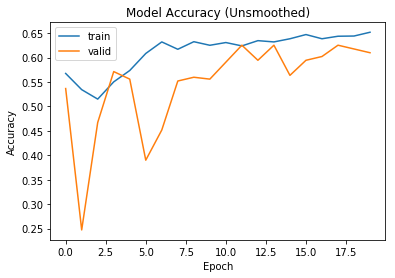

In [110]:
# Evaluation 

# Now our model is built and trained and tested; we look at results
# First, the loss and accuracy on training+validation data.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy (Unsmoothed)')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

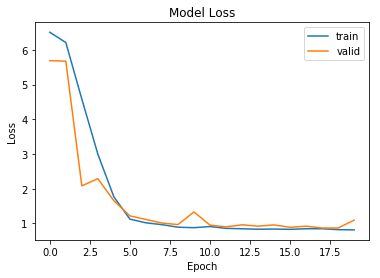

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [112]:
# Defining a function to plot smoother plots of validation and accuracy - this often helps to identify a trend better
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

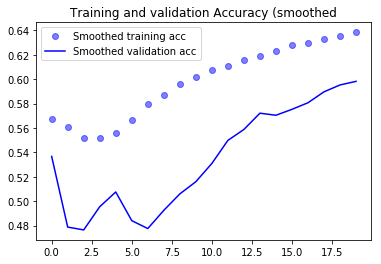

In [113]:
plt.figure()
plt.plot(smooth_curve(history.history['acc']), 'bo', label='Smoothed training acc', alpha=0.5)
plt.plot(smooth_curve(history.history['val_acc']), 'b', label='Smoothed validation acc')
plt.title('Training and validation Accuracy (smoothed')
plt.legend()
plt.show()

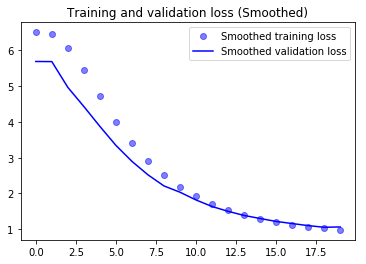

In [114]:
plt.figure()
plt.plot(smooth_curve(history.history['loss']), 'bo', label='Smoothed training loss', alpha=0.5)
plt.plot(smooth_curve(history.history['val_loss']), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss (Smoothed)')
plt.legend()
plt.show()

In [115]:
# Now let's see the results on Test data; rather than just training and validation sets
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Note that in multi-class and imbalanced classification problems, test accuracy is not an ideal metric')

Test loss: 1.0033403144896238
Test accuracy: 0.6132404191568753
Note that in multi-class and imbalanced classification problems, test accuracy is not an ideal metric


In [116]:
confusion = confusion_matrix(y_test.argmax(axis=1), predicted_labels)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[162   1   4]
 [ 54   3   0]
 [ 51   1  11]]


In [117]:
#This longer code gets a prettier confusion matrix.
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap != None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', ax=ax) # Changing cm_perc to cm give a heatmap in terms of the percentages instead of absolute number 
    plt.savefig(filename)

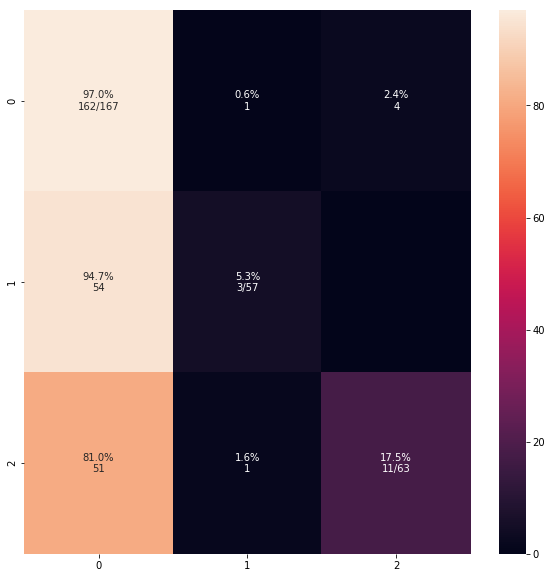

In [118]:
y_true = y_test.argmax(axis=1)
cm_analysis(y_true, predicted_labels, filename='CNN_Example.png', labels=[0,1,2])